## Zadání úlohy:

V této úloze použijeme PINN k řešení okrajového problému rovnice vedení tepla a následně porovnáme s analytickým řešením:

$$\begin{gather*}
    \frac{\partial u(x,\,y,\,t)}{\partial t} = \alpha^2 \cdot \Delta u(x,\,y,\,t), \quad t\in[0, t_0]\\
    u(0,\,y,\,t) = u(a,\,y,\,t) = 0 \\
    u(x,\,0,\,t) = u(x,\,b,\,t) = 0 \\
    u(x,\,y,\,0) = \sin(\frac{\pi x}{a})\sin(\frac{\pi y}{b}) - 3\sin(\frac{5\pi x}{a})\sin(\frac{5\pi y}{b})
\end{gather*}$$

kde $0 \leq x \leq a \land 0 \leq y \leq b$.
\
Pro $a = b = 2$ a $\alpha^2 = 1.14$ je analytické řešení dáno:
$$\begin{equation*}
    u(x,\,y,\,t) = \sin(\frac{\pi x}{2})\sin(\frac{\pi y}{2})e^{-1.14\pi^2t/2} - 3\sin(\frac{5\pi x}{2})\sin(\frac{5\pi y}{2})e^{-1.14\cdot25\pi^2t/2}
\end{equation*}$$
\
Neuronová síť tak bude mít tři vstupní neurony (x, y, t) a jeden výstupní. Doménou bude "CubeDomain" -- 3d krychle, jejíž první dva rozměry představují prostorové souřadnice, a třetí představuje časovou souřadnici.


In [113]:
# prvotni import

import torch
from torch.autograd import grad
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
import sys
from numpy import pi
sys.path.append('..')

In [114]:
# vlastni import
from src import train, utils
from src import calculus as calc
import src.data.cube_domain as cb
import src.models.mlp_model as mm

In [115]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [116]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [117]:
# konstanty (parametry problemu)
ALPHA = 1.14
A = 2
B = 2
T_MAX = 0.1

In [118]:
l_bounds = [0, 0, 0]
u_bounds = [A, B, T_MAX]

plot_ctx = utils.PlotContext(
    l_bounds=l_bounds,
    u_bounds=u_bounds,
    patches=[],
    colour_map='inferno',
    vmin=-3,
    vmax=4,
    device=device,
    N=100
)

In [119]:
def initial_condition(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(pi * x[:, 0:1] / A) * torch.sin(pi * x[:, 1:2] / B) - 3 * torch.sin(5 * pi * x[:, 0:1] / A) * torch.sin(5 * pi * x[:, 1:2] / B)

def analytical_solution(x: torch.Tensor) -> torch.Tensor:
    return torch.sin(pi * x[:, 0:1] / A) * torch.sin(pi * x[:, 1:2] / B) * torch.exp(-ALPHA * pi**2 * x[:, 2:3] * (A**2 + B**2) / ((A * B)**2)) +\
           (-3) * torch.sin(5 * pi * x[:, 0:1] / A) * torch.sin(5 * pi * x[:, 1:2] / B) * torch.exp(-ALPHA * 25 * pi**2 * x[:, 2:3] * (A**2 + B**2) / ((A * B)**2))

#utils.plot_function_on_2d_cube(lambda x: initial_condition(torch.cat((x[:, 0:2], torch.zeros((x.shape[0], 1))), dim=1)), plot_ctx)

In [120]:
def pde_residuum(pde_input: torch.Tensor, model: torch.nn.Module) -> torch.Tensor:
    # PDE ztrata:
    pde_output = model(pde_input)
    u_t = grad(pde_output, pde_input, torch.ones_like(pde_output), create_graph=True)[0][:, -1:]
    #print(u_t)
    laplacian = calc.laplacian(pde_input, pde_output, device=device)
    return u_t - ALPHA * laplacian

def loss_fn(model: torch.nn.Module, domain: cb.CubeDomain) -> torch.Tensor:
    # PDE ztrata:
    pde_input = domain.interior.requires_grad_(True)
    pde_res = pde_residuum(pde_input, model)
    pde_loss = torch.mean((pde_res)**2)

    # ztrata na hranicich:
    side_input = domain.get_side_points(2).requires_grad_(True)
    side_output = model(side_input)
    side_loss = torch.mean(side_output**2)

    # ztrata na pocatku
    initial_input = domain.sides[-1][0].requires_grad_(True)
    init_output = model(initial_input)
    init_values = initial_condition(initial_input)
    init_loss = torch.mean((init_output - init_values)**2)

    return [pde_loss, side_loss, 1000 * init_loss]

# ztrata pomoci L2 normy
def loss_l2(model: torch.nn.Module, domain: cb.CubeDomain) -> torch.Tensor:
    return calc.L2_norm(model, analytical_solution, 3, u_bounds, l_bounds, device, 50)

In [121]:
model_ctx = mm.ModelContext(
    l_bounds=l_bounds,
    u_bounds=u_bounds,
    input_dim=3,
    output_dim=1,
    layer=[64, 64, 64]
)

model = mm.MLPModel(model_ctx).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
scheduler = ReduceLROnPlateau(optimizer, patience=200, factor=0.75)

In [122]:
domain_ctx = cb.CubeContext(
    l_bounds=l_bounds,
    u_bounds=u_bounds,
    dim=3,
    N_int=10_000,
    N_sides=[(100, 100), (100, 100), (1_000, 100)],
    device=device,
)

domain = cb.CubeDomain(domain_ctx)

In [123]:
train_ctx = train.TrainingContext(
    model=model,
    optimizer=optimizer,
    domain=domain,
    loss_fn=loss_fn,
    epochs=10_000,
    monitor_lr=True,
)

total_loss_values, component_loss_values = train.train_switch_to_lbfgs(train_ctx, lbfgs_lr=0.1, epochs_with_lbfgs=500)

Loss at epoch 1 is: 2567.967041015625. Current learing rate: 0.005 
Loss at epoch 100 is: 1811.670166015625. Current learing rate: 0.005 
Loss at epoch 200 is: 910.9833984375. Current learing rate: 0.005 
Loss at epoch 300 is: 580.7257080078125. Current learing rate: 0.005 
Loss at epoch 400 is: 205.831787109375. Current learing rate: 0.005 
Loss at epoch 500 is: 114.41158294677734. Current learing rate: 0.005 
Loss at epoch 600 is: 65.53313446044922. Current learing rate: 0.005 
Loss at epoch 700 is: 32.23541259765625. Current learing rate: 0.005 
Loss at epoch 800 is: 25.426929473876953. Current learing rate: 0.005 
Loss at epoch 900 is: 42.123207092285156. Current learing rate: 0.005 
Loss at epoch 1000 is: 30.018882751464844. Current learing rate: 0.005 
Loss at epoch 1100 is: 26.75455665588379. Current learing rate: 0.005 
Loss at epoch 1200 is: 30.249801635742188. Current learing rate: 0.005 
Loss at epoch 1300 is: 49.49591827392578. Current learing rate: 0.005 
Loss at epoch 140

In [124]:
norm = calc.L2_norm(model, analytical_solution, 3, u_bounds, l_bounds, device, n=50)
print(f"L2 norma mezi modelem a analytickým řešením je {norm}")

L2 norma mezi modelem a analytickým řešením je 0.018832344561815262


/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)
/home/berva/Projects/PINNs/Introduction/notebooks/../src/utils.py:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_x_labels)


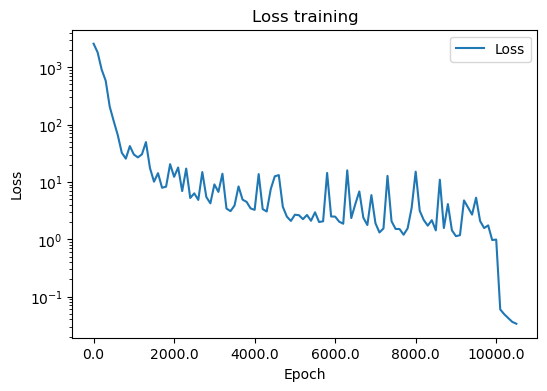

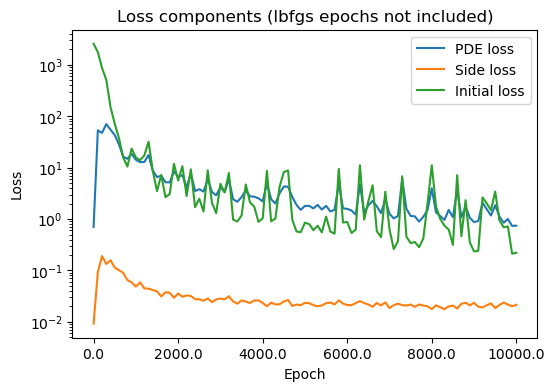

In [125]:
plot_ctx.x_label = 'Epoch'
plot_ctx.y_label = 'Loss'

plot_ctx.title = 'Loss training'
utils.plot_loss_values({'Loss': total_loss_values}, plot_ctx)
plot_ctx.title = 'Loss components (lbfgs epochs not included)'
utils.plot_loss_values({'PDE loss': component_loss_values[0], 'Side loss': component_loss_values[1], 'Initial loss': component_loss_values[2]}, plot_ctx)

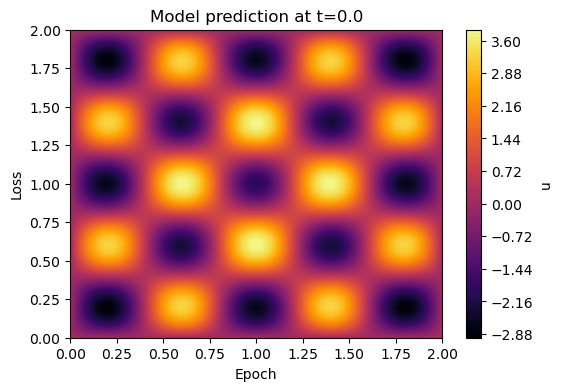

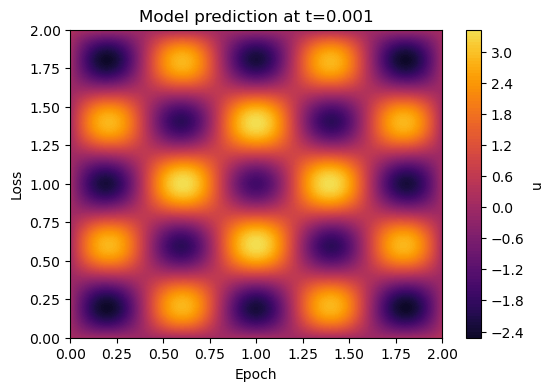

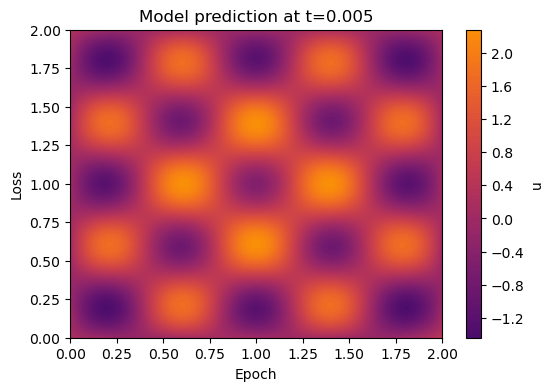

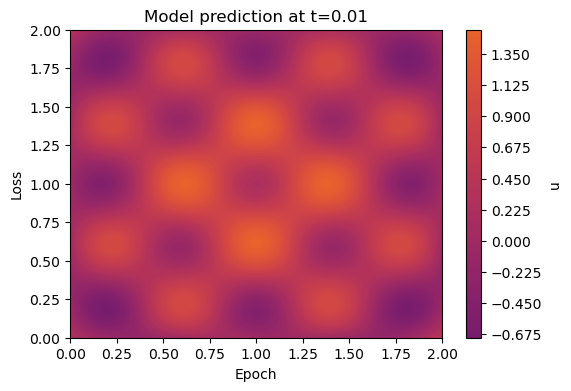

In [126]:
def solution_in_time(function, x: torch.Tensor, time: float) -> torch.Tensor:
    time_tensor = torch.full((x.shape[0], 1), time, device=device)
    input_ = torch.cat((x, time_tensor), dim=1)
    return function(input_)


times = [0.0, 0.001, 0.005, 0.01]

for time in times:
    plot_ctx.title = f"Model prediction at t={time}"
    utils.plot_function_on_2d_cube(lambda x: solution_in_time(model, x, time), plot_ctx)

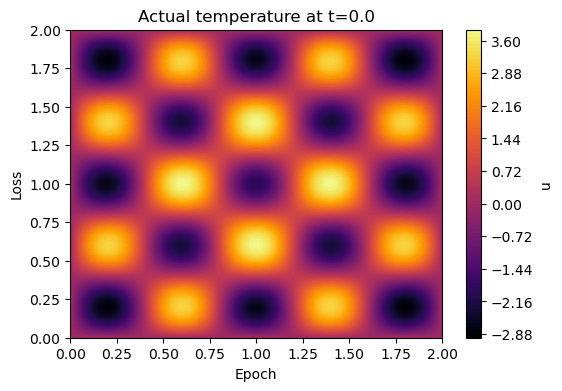

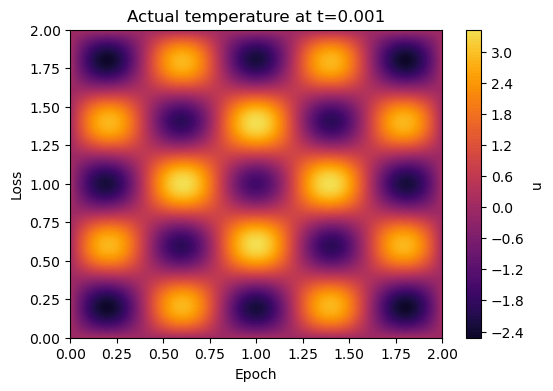

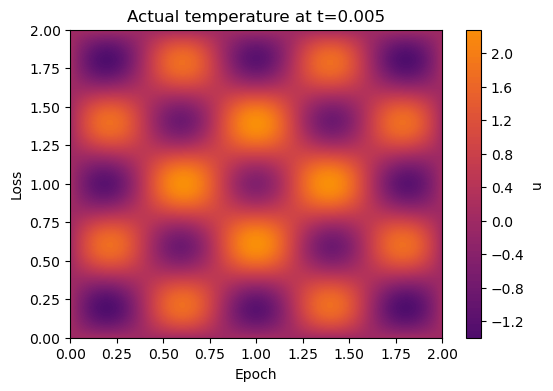

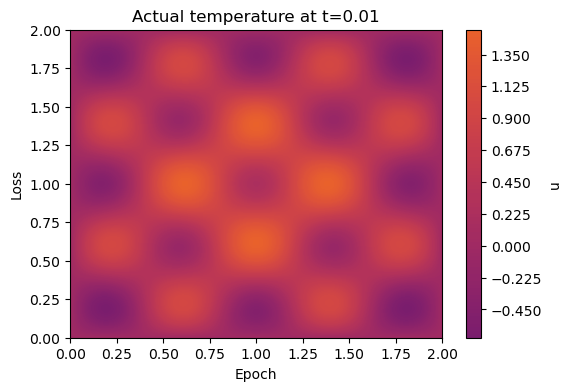

In [127]:
for time in times:
    plot_ctx.title = f"Actual temperature at t={time}"
    utils.plot_function_on_2d_cube(lambda x: solution_in_time(analytical_solution, x, time), plot_ctx)